In [72]:
import numpy as np
from os import path
from skimage import io
from skimage.transform import rescale
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm


Functions for loading data

In [79]:
LABELS = 'labels.csv'
IMGS = 'img'

def load_image(filename):
    img = io.imread(filename, as_gray=True) # use built-in grayscale loading
    crop = img[90:180, 54:124] # crop to face
    return crop

def load_data(folder, column):
    filenames, y = np.genfromtxt(
        path.join(folder,LABELS),
        usecols=(1,column), # col 1 contains the filenames
        dtype='U10,i8',
        unpack=True,
        skip_header=1,
        delimiter='\t'
    )
    imagedir = path.join(folder,IMGS)
    n = len(filenames)
    shape = load_image(path.join(imagedir,filenames[0])).shape # get first image to get shape
    X = np.empty((n, *shape)) # pre-define X, as this will be much more efficient than concatenating arrays
    for i in tqdm(range(n), desc=folder): # tqdm displays a nice loading bar
        X[i] = load_image(path.join(imagedir,filenames[i]))
    print(f'Loaded {X.nbytes:,} bytes')
    return X, y


Test load labels

In [80]:
DATASET = 'Datasets/celeba'
FEATURE = 2 # column 2 contains gender


In [81]:
X, y = load_data(DATASET, FEATURE)


Datasets/celeba:   0%|          | 0/5000 [00:00<?, ?it/s]

Loaded 252,000,000 bytes


Loaded 252,000,000 bytes


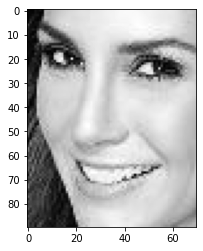

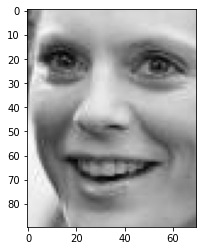

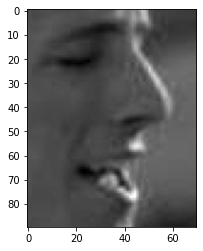

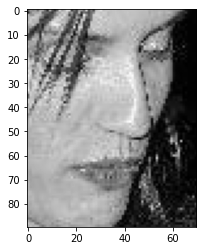

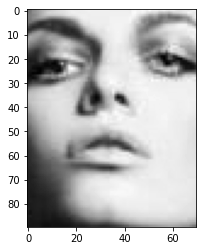

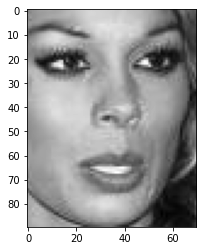

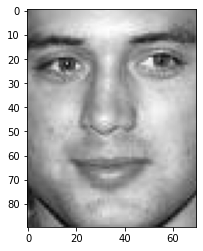

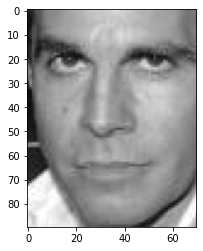

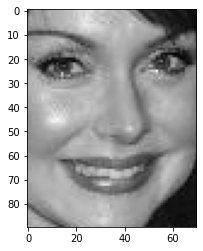

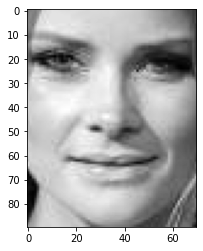

In [68]:
for i in range(10):
    plt.imshow(X[i], cmap='gray')
    plt.show()